# MoonBoard grade classification model using set transformer

In [8]:
# import modules
import torch

In [9]:
import numpy as np
import json
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import os
from modules import ISAB, SAB, PMA

In [10]:
# Mappings --------------------------------------------------------
# Map each hold like "A1"…"K18" to an integer 0…(11*18−1)=197
cols = [chr(c) for c in range(ord('A'), ord('K')+1)]
rows = list(range(1, 19))
hold_to_idx = {f"{c}{r}": i for i, (c, r) in enumerate((c, r) for r in rows for c in cols)}


# Map grades "V4"…"V11" 
grade_to_label = {f"V{i}": i - 4 for i in range(4, 12)}  
label_to_grade = {v: k for k, v in grade_to_label.items()}

In [11]:
# Dataset ---------------------------------------------------------
class MoonBoardDataset(Dataset):
    def __init__(self, json_path, hold_to_idx, grade_to_label, embed_dim):
        self.hold_to_idx = hold_to_idx
        self.grade_to_label = grade_to_label
        self.embedding = nn.Embedding(len(hold_to_idx), embed_dim)
        # load all lines
        with open(json_path, 'r') as f:
            self.raw = [json.loads(line) for line in f]

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        item = self.raw[idx]
        try:
            hold_idxs = torch.tensor([self.hold_to_idx[h] for h in item['holds']], dtype=torch.long)
        except KeyError as e:
            print(f"[ERROR] Problem name: {item.get('problem_name', 'UNKNOWN')}")
            print(f"[ERROR] Invalid hold found in item {idx}: {item['holds']}")
            raise e
        holds_emb = self.embedding(hold_idxs)
        label = torch.tensor(self.grade_to_label[item['grade']], dtype=torch.long)
        return holds_emb, label

In [ ]:
# Classifier Model -----------------------------------------------

class SetTransformerClassifier(nn.Module):
    def __init__(self, dim_in=64, dim_hidden=128, num_heads=4, num_inds=32, num_classes=11):
        super().__init__()
        self.encoder = nn.Sequential(
            ISAB(dim_in, dim_hidden, num_heads, num_inds, ln=True),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=True),
        )
        self.decoder = nn.Sequential(
            PMA(dim_hidden, num_heads, 1, ln=True),
            nn.Flatten(start_dim=1),
            nn.Linear(dim_hidden, num_classes)
        )

    def forward(self, x):
        # x: (B, N, dim_in)
        x_enc = self.encoder(x)
        out = self.decoder(x_enc)    # (B, num_classes)
        return out

In [ ]:
# Training Loop --------------------------------------------------
def evaluate(model, dataloader, device):
    model.eval()
    strict_correct, loose_correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            total += y.size(0)
            strict_correct += (preds == y).sum().item()
            loose_correct += ((preds - y).abs() <= 1).sum().item()

    strict_acc = 100.0 * strict_correct / total
    loose_acc = 100.0 * loose_correct / total
    print(f"Strict Accuracy: {strict_correct}/{total} ({strict_acc:.2f}%)")
    print(f"±1 Grade Accuracy: {loose_correct}/{total} ({loose_acc:.2f}%)")

def collate_batch(batch):
    X_batch = [x for x, _ in batch]
    y_batch = [y for _, y in batch]
    X_padded = pad_sequence(X_batch, batch_first=True)  # (B, max_len, embed_dim)
    y_tensor = torch.stack(y_batch)
    return X_padded, y_tensor

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# --- Hyperparameters ---
json_path = './cleaned_moonboard_problems.json'
embed_dim = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
lr = 1e-4
epochs = 30

def train():
    # --- Load full dataset ---
    full_dataset = MoonBoardDataset(json_path, hold_to_idx, grade_to_label, embed_dim)

    # --- Extract targets for stratified split ---
    targets = [grade_to_label[item['grade']] for item in full_dataset.raw]
    # for i in range(0, 10):  # 1 to 5
    #     print(f"{i}: {targets.count(i)}")
        

    # --- compute weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(targets),
        y=targets
    )

    # --- convert to torch tensor
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # --- Split indices ---
    train_idx, val_idx = train_test_split(
        list(range(len(full_dataset))),
        test_size=0.2,
        stratify=targets,
        random_state=42
    )

    # --- Subset datasets ---
    from torch.utils.data import Subset
    train_data = Subset(full_dataset, train_idx)
    val_data = Subset(full_dataset, val_idx)

    # --- DataLoaders ---
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    # --- Model, loss, optimizer ---
    model = SetTransformerClassifier(dim_in=embed_dim, num_classes=len(grade_to_label)-1).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    ## TODO Seperate training loop into a function

    # --- Training loop ---
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch:02d} — loss: {total_loss / len(train_loader):.4f}")

    # --- Save and evaluate ---
    torch.save(model.state_dict(), 'set_transformer_moonboard.pth')
    
    print("Training complete. Model saved.")
    evaluate(model, val_loader, device)
    return val_loader

if __name__ == '__main__':
    val_loader = train()

Epoch 01 — loss: 1.7077
Epoch 02 — loss: 1.6274
Epoch 03 — loss: 1.5960
Epoch 04 — loss: 1.5600
Epoch 05 — loss: 1.5278
Epoch 06 — loss: 1.4999
Epoch 07 — loss: 1.4646
Epoch 08 — loss: 1.4344
Epoch 09 — loss: 1.3989
Epoch 10 — loss: 1.3693
Epoch 11 — loss: 1.3393
Epoch 12 — loss: 1.3048
Epoch 13 — loss: 1.2801
Epoch 14 — loss: 1.2453
Epoch 15 — loss: 1.2164
Epoch 16 — loss: 1.1856
Epoch 17 — loss: 1.1461
Epoch 18 — loss: 1.1130
Epoch 19 — loss: 1.0956
Epoch 20 — loss: 1.0562
Epoch 21 — loss: 1.0268
Epoch 22 — loss: 0.9996
Epoch 23 — loss: 0.9664
Epoch 24 — loss: 0.9401
Epoch 25 — loss: 0.9261
Epoch 26 — loss: 0.8893
Epoch 27 — loss: 0.8662
Epoch 28 — loss: 0.8513
Epoch 29 — loss: 0.8294
Epoch 30 — loss: 0.7868
Training complete. Model saved.
Strict Accuracy: 1356/3462 (39.17%)
±1 Grade Accuracy: 2638/3462 (76.20%)


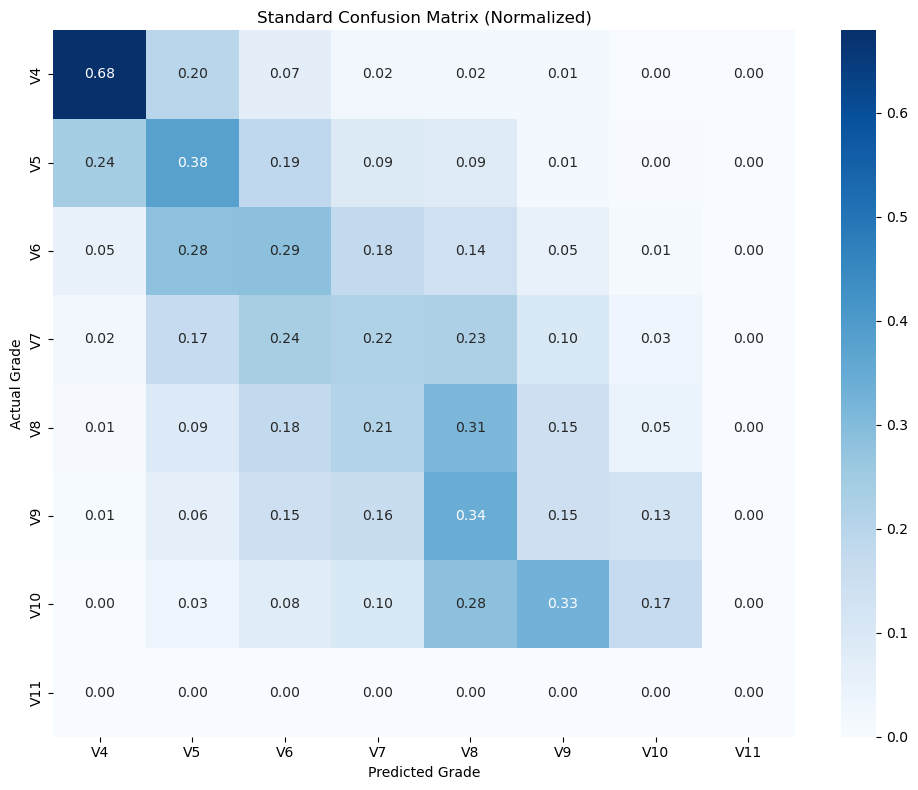

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices_with_tolerance(model, dataloader, device, class_labels):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # --- Standard Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)), normalize='true')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Standard Confusion Matrix (Normalized)")
    plt.xlabel("Predicted Grade")
    plt.ylabel("Actual Grade")
    plt.tight_layout()
    plt.show()

    # Overall tolerant accuracy
    total_correct = np.sum([
        cm[i, j]
        for i in range(len(class_labels))
        for j in range(len(class_labels))
        if abs(i - j) <= 1
    ])
    
model = SetTransformerClassifier(dim_in=embed_dim, num_classes=len(grade_to_label)-1).to(device)
model.load_state_dict(torch.load("set_transformer_moonboard.pth"))
class_labels = [f"V{i}" for i in range(4, 12)]  # V4–V11
plot_confusion_matrices_with_tolerance(model, val_loader, device, class_labels)